### exp: eqtl prediction, slope prediction, dnabert2 for machine learning

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
model_size = ['small','middle','large']
model_list = ['xgboost','lightgbm','random forest','knn','svm']
tissue = 'Nerve_Tibial'
data_path = '../../../../../datasets_embedding/dnabert2/eqtl_datasets/slope_prediction/' + tissue + '/'
image_path = 'images_shuffled_seed17/'
# set seed
seed = 17
import random
random.seed(seed)
np.random.seed(seed)

#### small model

In [3]:
model = model_size[0]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

merged_data = pd.concat([train_data, valid_data, test_data]) # for machine learning, grid search
# new split
merged_data = merged_data.sample(frac=1).reset_index(drop=True)
train_data = merged_data[0:int(0.9*len(merged_data))].reset_index(drop=True)
test_data = merged_data[int(0.9*len(merged_data)):].reset_index(drop=True)

sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['dnabert_before'][i].flatten().tolist()
    feature_list += train_data['dnabert_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['slope'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['dnabert_before'][i].flatten().tolist()
    feature_list += test_data['dnabert_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['slope'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

         phenotype_id             variant_id  tss_distance       maf  \
0   ENSG00000242485.5   chr1_1407232_G_C_b38           -81  0.182648   
1  ENSG00000157881.13   chr1_2526571_G_C_b38           -57  0.020548   
2   ENSG00000231789.2   chr1_9687685_C_T_b38           130  0.043379   
3   ENSG00000272084.1  chr1_19075748_C_A_b38           237  0.109589   
4   ENSG00000090432.6  chr1_20508117_C_A_b38           -44  0.110599   

  ma_samples ma_count  pval_nominal     slope  slope_se  \
0        147      160  3.926291e-46  0.436504  0.026472   
1         17       18  5.059731e-09  0.500525  0.083591   
2         36       38  1.409246e-08  0.738330  0.127241   
3         91       96  7.632423e-09  0.404185  0.068344   
4         93       96  3.275938e-73  0.996535  0.043319   

                                          seq_before  \
0  gcactccagcctgggtgacagcgcgagactccgtctcggggtaaga...   
1  cgaaaagggagtaattcgcgttcctcccctagaggtggctgggagg...   
2  tgtggcccaggctggtcttgaactcctgggctcaagtgatc

##### model 1: xgboost

In [4]:
# model 1: xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 300, 10, dtype=int)} # 
xgb_model = xgb.XGBRegressor(seed=seed)
# https://scikit-learn.org/stable/modules/model_evaluation.html
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='neg_mean_absolute_error')
gs.fit(X_train,Y_train)
n_estimators = gs.best_params_['n_estimators']
print(gs.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 
xgb_model = xgb.XGBRegressor(seed=seed,n_estimators=n_estimators)
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='neg_mean_absolute_error')
gs.fit(X_train,Y_train)
max_depth = gs.best_params_['max_depth']
print(gs.best_params_)

{'n_estimators': 74}
{'max_depth': 4}


rmse= 0.9075553319724006
r2= -0.1526490910987981
pcc= 0.17140364566201396
pcc_p= 0.2547129372836106


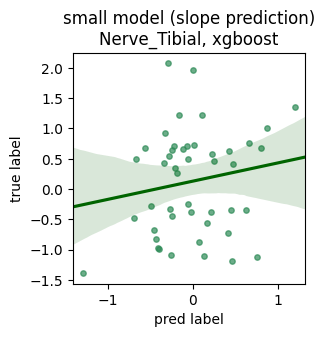

In [5]:
ml_model = model_list[0]

clf_xgb = xgb.XGBRegressor(n_estimators=n_estimators,  max_depth=max_depth) # from grid search
clf_xgb.fit(X_train,Y_train)

y_pred = clf_xgb.predict(X_test)                                   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#2E8B57','alpha':0.7,'s':15}, line_kws={"color": "#006400"},truncate=False)
plt.title('small model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-small-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:lightgbm

In [6]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': np.linspace(1, 50, 10, dtype=int)} # 
gbm = lgb.LGBMRegressor(seed=seed,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='neg_mean_absolute_error')
gsearch.fit(X_train, Y_train)
max_depth = gsearch.best_params_['max_depth']
print(gsearch.best_params_)

cv_params = {'num_leaves': np.linspace(2, 50, 5, dtype=int)} # 
gbm = lgb.LGBMRegressor(seed=seed,max_depth=max_depth,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='neg_mean_absolute_error')
gsearch.fit(X_train, Y_train)
num_leaves = gsearch.best_params_['num_leaves']
print(gsearch.best_params_)

{'max_depth': 17}
{'num_leaves': 26}


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.283472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 210694
[LightGBM] [Info] Number of data points in the train set: 410, number of used features: 1536
[LightGBM] [Info] Start training from score 0.052410
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

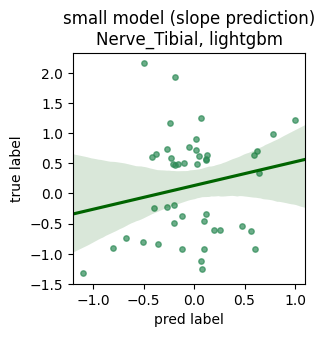

In [7]:
ml_model = model_list[1]

clf_lgb = lgb.LGBMRegressor(max_depth=max_depth, num_leaves=num_leaves)
clf_lgb.fit(X_train,Y_train)

y_pred = clf_lgb.predict(X_test)                                   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#2E8B57','alpha':0.7,'s':15}, line_kws={"color": "#006400"},truncate=False)
plt.title('small model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-small-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: random forest

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 200, 10, dtype=int)} # 200
rfModel = RandomForestRegressor(random_state = random.seed(seed))
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train)
n_estimators = grid.best_params_['n_estimators']
print(grid.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 200
rfModel = RandomForestRegressor(random_state = random.seed(seed),n_estimators=n_estimators)
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train)
max_depth=grid.best_params_['max_depth']
print(grid.best_params_)

{'n_estimators': 31}
{'max_depth': 8}


rmse= 0.8107788237951877
r2= 0.08006809541287119
pcc= 0.31637817927359657
pcc_p= 0.032186271297579096


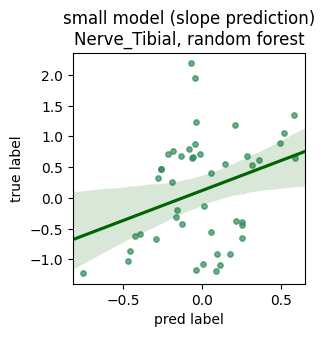

In [9]:
ml_model = model_list[2]
clf_rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
clf_rf.fit(X_train,Y_train)

y_pred = clf_rf.predict(X_test)        

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#2E8B57','alpha':0.7,'s':15}, line_kws={"color": "#006400"},truncate=False)
plt.title('small model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-small-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 4: knn

In [10]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# 1:search 'n_estimators'
paramGride = {'n_neighbors': np.linspace(100, 300, 10, dtype=int)} 

knnModel = KNeighborsRegressor()
grid = GridSearchCV(
    knnModel,paramGride,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid = grid.fit(X_train,Y_train)
grid.best_params_

{'n_neighbors': 100}

rmse= 0.8524105684437288
r2= -0.016830438102892753
pcc= 0.018359856822860867
pcc_p= 0.9036072376474465


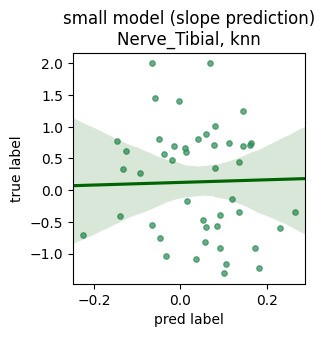

In [11]:
ml_model = model_list[3]
clf_knn = KNeighborsRegressor(n_neighbors = grid.best_params_['n_neighbors'])
clf_knn.fit(X_train,Y_train)

y_pred = clf_knn.predict(X_test)    

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#2E8B57','alpha':0.7,'s':15}, line_kws={"color": "#006400"},truncate=False)
plt.title('small model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-small-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 5: svm

In [12]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

cv_params = {'gamma': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} # 33
svmModel = SVR()
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid = grid.fit(X_train,Y_train)
gamma = grid.best_params_['gamma']
print(grid.best_params_)

cv_params = {'C': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} # 33
svmModel = SVR(gamma=gamma)
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid = grid.fit(X_train,Y_train)
C = grid.best_params_['C']
print(grid.best_params_)

{'gamma': 10}
{'C': 100}


rmse= 0.7912119737949156
r2= 0.12393447774932642
pcc= 0.36079798403295216
pcc_p= 0.013766282235285372


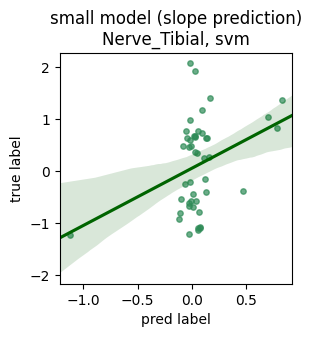

In [13]:
ml_model = model_list[4]
clf_svm = SVR(gamma = gamma, C = C)
clf_svm.fit(X_train,Y_train)

y_pred = clf_svm.predict(X_test)  

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#2E8B57','alpha':0.7,'s':15}, line_kws={"color": "#006400"},truncate=False)
plt.title('small model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-small-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

#### middle model

In [3]:
model = model_size[1]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

merged_data = pd.concat([train_data, valid_data, test_data]) # for machine learning, grid search
# new split
merged_data = merged_data.sample(frac=1).reset_index(drop=True)
train_data = merged_data[0:int(0.9*len(merged_data))].reset_index(drop=True)
test_data = merged_data[int(0.9*len(merged_data)):].reset_index(drop=True)

sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['dnabert_before'][i].flatten().tolist()
    feature_list += train_data['dnabert_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['slope'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['dnabert_before'][i].flatten().tolist()
    feature_list += test_data['dnabert_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['slope'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

         phenotype_id            variant_id  tss_distance       maf  \
0   ENSG00000272512.1   chr1_989148_C_A_b38         -8903  0.455742   
1   ENSG00000272512.1   chr1_999842_C_A_b38          1791  0.444064   
2  ENSG00000008128.22  chr1_1733506_G_A_b38          9182  0.013699   
3  ENSG00000008130.15  chr1_1777680_C_T_b38         -2777  0.076484   
4   ENSG00000182873.5  chr1_2189679_C_T_b38          5290  0.378995   

  ma_samples ma_count  pval_nominal     slope  slope_se  \
0        315      400  6.301756e-45  0.753825  0.046540   
1        301      389  2.103221e-49  0.757170  0.043822   
2         12       12  2.895097e-10  1.414804  0.218233   
3         66       67  3.749908e-13  0.248043  0.032905   
4        276      332  4.958885e-20  0.558117  0.057414   

                                          seq_before  \
0  cttccttttaatgaagtctaatttgcccatttttcttgatgtatta...   
1  cttccttttaatgaagtctaatttgcccatttttcttgatgtatta...   
2  ttcagaatggataatttctactgctccatccacaagttgtttccaa.

##### model 1: xgboost

In [15]:
# model 1: xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 300, 10, dtype=int)} # 
xgb_model = xgb.XGBRegressor(seed=seed)
# https://scikit-learn.org/stable/modules/model_evaluation.html
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='neg_mean_absolute_error')
gs.fit(X_train,Y_train)
n_estimators = gs.best_params_['n_estimators']
print(gs.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 
xgb_model = xgb.XGBRegressor(seed=seed,n_estimators=n_estimators)
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='neg_mean_absolute_error')
gs.fit(X_train,Y_train)
max_depth = gs.best_params_['max_depth']
print(gs.best_params_)

{'n_estimators': 138}
{'max_depth': 5}


rmse= 0.7061518137738422
r2= 0.07418799225285733
pcc= 0.4126208849008525
pcc_p= 0.00047112994202220924


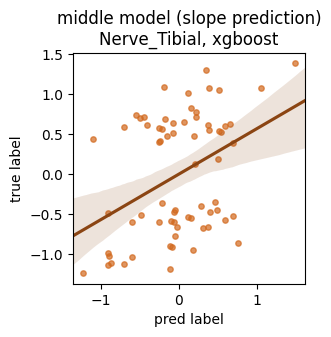

In [16]:
ml_model = model_list[0]

clf_xgb = xgb.XGBRegressor(n_estimators=n_estimators,  max_depth=max_depth) # from grid search
clf_xgb.fit(X_train,Y_train)

y_pred = clf_xgb.predict(X_test)                                   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#D2691E','alpha':0.7,'s':15}, line_kws={"color": "#8B4513"},truncate=False)
plt.title('middle model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-middle-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:lightgbm

In [17]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': np.linspace(1, 50, 10, dtype=int)} # 
gbm = lgb.LGBMRegressor(seed=seed,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='neg_mean_absolute_error')
gsearch.fit(X_train, Y_train)
max_depth = gsearch.best_params_['max_depth']
print(gsearch.best_params_)

cv_params = {'num_leaves': np.linspace(2, 50, 5, dtype=int)} # 
gbm = lgb.LGBMRegressor(seed=seed,max_depth=max_depth,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='neg_mean_absolute_error')
gsearch.fit(X_train, Y_train)
num_leaves = gsearch.best_params_['num_leaves']
print(gsearch.best_params_)

{'max_depth': 17}
{'num_leaves': 26}


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.211434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 310104
[LightGBM] [Info] Number of data points in the train set: 604, number of used features: 1536
[LightGBM] [Info] Start training from score 0.061610
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

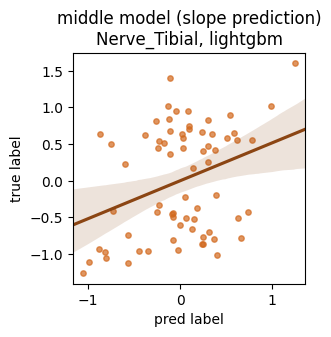

In [18]:
ml_model = model_list[1]
clf_lgb = lgb.LGBMRegressor(max_depth=max_depth, num_leaves=num_leaves)
clf_lgb.fit(X_train,Y_train)

y_pred = clf_lgb.predict(X_test)   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#D2691E','alpha':0.7,'s':15}, line_kws={"color": "#8B4513"},truncate=False)
plt.title('middle model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-middle-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 200, 10, dtype=int)} # 200
rfModel = RandomForestRegressor(random_state = random.seed(seed))
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train)
n_estimators = grid.best_params_['n_estimators']
print(grid.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 200
rfModel = RandomForestRegressor(random_state = random.seed(seed),n_estimators=n_estimators)
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train)
max_depth=grid.best_params_['max_depth']
print(grid.best_params_)

In [ ]:
ml_model = model_list[2]
clf_rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
clf_rf.fit(X_train,Y_train)

y_pred = clf_rf.predict(X_test)         

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#D2691E','alpha':0.7,'s':15}, line_kws={"color": "#8B4513"},truncate=False)
plt.title('middle model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-middle-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 4: knn

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# 1:search 'n_estimators'
paramGride = {'n_neighbors': np.linspace(100, 300, 10, dtype=int)} 

knnModel = KNeighborsRegressor()
grid = GridSearchCV(
    knnModel,paramGride,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid = grid.fit(X_train,Y_train)
grid.best_params_

In [ ]:
ml_model = model_list[3]
clf_knn = KNeighborsRegressor(n_neighbors = grid.best_params_['n_neighbors'])
clf_knn.fit(X_train,Y_train)

y_pred = clf_knn.predict(X_test)  

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#D2691E','alpha':0.7,'s':15}, line_kws={"color": "#8B4513"},truncate=False)
plt.title('middle model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-middle-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 5: svm

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

cv_params = {'gamma': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} # 33
svmModel = SVR()
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid = grid.fit(X_train,Y_train)
gamma = grid.best_params_['gamma']
print(grid.best_params_)

cv_params = {'C': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} # 33
svmModel = SVR(gamma=gamma)
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid = grid.fit(X_train,Y_train)
C = grid.best_params_['C']
print(grid.best_params_)

In [ ]:
ml_model = model_list[4]
clf_svm = SVR(gamma = gamma, C = C)
clf_svm.fit(X_train,Y_train)

y_pred = clf_svm.predict(X_test)      

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#D2691E','alpha':0.7,'s':15}, line_kws={"color": "#8B4513"},truncate=False)
plt.title('middle model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-middle-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

#### large model

In [ ]:
model = model_size[2]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

merged_data = pd.concat([train_data, valid_data, test_data]) # for machine learning, grid search
# new split
merged_data = merged_data.sample(frac=1).reset_index(drop=True)
train_data = merged_data[0:int(0.9*len(merged_data))].reset_index(drop=True)
test_data = merged_data[int(0.9*len(merged_data)):].reset_index(drop=True)

sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['dnabert_before'][i].flatten().tolist()
    feature_list += train_data['dnabert_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['slope'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['dnabert_before'][i].flatten().tolist()
    feature_list += test_data['dnabert_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['slope'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

##### model 1: xgboost

In [ ]:
# model 1: xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 300, 10, dtype=int)} # 
xgb_model = xgb.XGBRegressor(seed=seed)
# https://scikit-learn.org/stable/modules/model_evaluation.html
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='neg_mean_absolute_error')
gs.fit(X_train,Y_train)
n_estimators = gs.best_params_['n_estimators']
print(gs.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 
xgb_model = xgb.XGBRegressor(seed=seed,n_estimators=n_estimators)
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='neg_mean_absolute_error')
gs.fit(X_train,Y_train)
max_depth = gs.best_params_['max_depth']
print(gs.best_params_)

In [ ]:
ml_model = model_list[0]
clf_xgb = xgb.XGBRegressor(n_estimators=n_estimators,  max_depth=max_depth) # from grid search
clf_xgb.fit(X_train,Y_train)

y_pred = clf_xgb.predict(X_test)                                   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#800080','alpha':0.7,'s':15}, line_kws={"color": "#4B0082"},truncate=False)
plt.title('large model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-large-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:lightgbm

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': np.linspace(1, 50, 10, dtype=int)} # 
gbm = lgb.LGBMRegressor(seed=seed,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='neg_mean_absolute_error')
gsearch.fit(X_train, Y_train)
max_depth = gsearch.best_params_['max_depth']
print(gsearch.best_params_)

cv_params = {'num_leaves': np.linspace(2, 50, 5, dtype=int)} # 
gbm = lgb.LGBMRegressor(seed=seed,max_depth=max_depth,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='neg_mean_absolute_error')
gsearch.fit(X_train, Y_train)
num_leaves = gsearch.best_params_['num_leaves']
print(gsearch.best_params_)

In [ ]:
ml_model = model_list[1]
clf_lgb = lgb.LGBMRegressor(max_depth=max_depth, num_leaves=num_leaves)
clf_lgb.fit(X_train,Y_train)

y_pred = clf_lgb.predict(X_test)         

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#800080','alpha':0.7,'s':15}, line_kws={"color": "#4B0082"},truncate=False)
plt.title('large model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-large-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 200, 10, dtype=int)} # 200
rfModel = RandomForestRegressor(random_state = random.seed(seed))
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train)
n_estimators = grid.best_params_['n_estimators']
print(grid.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 200
rfModel = RandomForestRegressor(random_state = random.seed(seed),n_estimators=n_estimators)
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train)
max_depth=grid.best_params_['max_depth']
print(grid.best_params_)

In [ ]:
ml_model = model_list[2]
clf_rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
clf_rf.fit(X_train,Y_train)

y_pred = clf_rf.predict(X_test)   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#800080','alpha':0.7,'s':15}, line_kws={"color": "#4B0082"},truncate=False)
plt.title('large model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-large-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 4: knn

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# 1:search 'n_estimators'
paramGride = {'n_neighbors': np.linspace(100, 300, 10, dtype=int)} 

knnModel = KNeighborsRegressor()
grid = GridSearchCV(
    knnModel,paramGride,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
grid.best_params_

In [ ]:
ml_model = model_list[3]
clf_knn = KNeighborsRegressor(n_neighbors = grid.best_params_['n_neighbors'])
clf_knn.fit(X_train,Y_train)

y_pred = clf_knn.predict(X_test)   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#800080','alpha':0.7,'s':15}, line_kws={"color": "#4B0082"},truncate=False)
plt.title('large model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-large-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 5: svm

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

cv_params = {'gamma': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} # 33
svmModel = SVR()
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid = grid.fit(X_train,Y_train)
gamma = grid.best_params_['gamma']
print(grid.best_params_)

cv_params = {'C': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} # 33
svmModel = SVR(gamma=gamma)
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid = grid.fit(X_train,Y_train)
C = grid.best_params_['C']
print(grid.best_params_)

In [ ]:
ml_model = model_list[4]
clf_svm = SVR(gamma = gamma, C = C)
clf_svm.fit(X_train,Y_train)

y_pred = clf_svm.predict(X_test)      

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#800080','alpha':0.7,'s':15}, line_kws={"color": "#4B0082"},truncate=False)
plt.title('large model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-large-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()